In [1]:
#导入相关包
import numpy as np
import torch as t
import random
import matplotlib.pyplot as plt
#import netCDF4
import datetime
import torch
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.autograd as autograd
import torch.nn.functional as F
from einops import rearrange, repeat
import os
#from config import args
#import seaborn as sns
#from global_land_mask import globe
#from scipy import interpolate
#plt.rcParams['font.sans-serif'] = ['SimHei'] #中文支持
%matplotlib inline

/mnt/miniconda3/envs/MJO_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 固定随机种子
SEED = 22

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)

In [3]:
path='/WdHeDisk/users/zhangnong/MJO/908_test/data/s2s_dataset_for7_7_35/'
wei = '_for7_7_35_sample.npy'

In [4]:
X_train=np.load(path+'X_train'+wei)
Y_train=np.load(path+'Y_train'+wei)
X_valid=np.load(path+'X_valid'+wei)
Y_valid=np.load(path+'Y_valid'+wei)
X_test=np.load(path+'X_test'+wei)
Y_test=np.load(path+'Y_test'+wei)

In [5]:
print(X_train.shape,Y_train.shape)
print(X_valid.shape,Y_valid.shape)

(9200, 7, 13, 144, 4) (9200, 35, 2)
(400, 7, 13, 144, 4) (400, 35, 2)


In [6]:
# 构造数据管道
class MJODataset(Dataset):
    def __init__(self, data,label):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.data[idx],self.label[idx]
batch_size = 16
#刚刚 batchsize = 32 还不错15～16天，lr = 1e-3， deacy = 0.001 ，数据集是22800， 1600， 1600， 模型三层4096， 1024， 90
#无dropout
trainset = MJODataset(X_train, Y_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validset = MJODataset(X_valid, Y_valid)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

testset = MJODataset(X_test, Y_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
print(len(trainloader))

575


In [7]:
if torch.cuda.is_available():
    device=torch.device("cuda:1")
else :
    device=torch.device("cpu")

In [8]:
#cnn模块
# 构建CNN单元
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if (in_channels == out_channels) and (stride == 1):
            self.res = lambda x: x
        else:
            self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        
    def forward(self, x):
        # 残差
        res = self.res(x)
        res = self.bn2(res)

        x = F.relu(self.bn1(x))
        x = self.conv(x)
        x = self.bn2(x)
        
        x = x + res
        
        return x

In [9]:
#编码
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 1
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)


    def forward(self, x):
        
        batch_size, T, C = x.shape
        
        h = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)

        
        #lstm训练
        output, (h, c) = self.lstm(x, (h, c))
        #output[batch_size, time_squence, hidden_size]
        #h[2, batch_size, hidden_size]

        return   h, c

In [10]:
#解码
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        #outsize = 45
        self.num_directions = 1  
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=False)
        
        self.lstm2 = nn.LSTM(self.hidden_size, 128, self.num_layers, batch_first = True)
        
        self.fc1 = nn.Linear(self.hidden_size, self.output_size)
        #self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.fc2 = nn.Linear(128, self.output_size)

    def forward(self, x, h, c):
        # x = [batchsize, input_size]
        batch_size = x.shape[0]
        x = x.view(batch_size, 1, self.input_size)
        
        output, (h, c) = self.lstm(x, (h, c))
        
        # output(batch_size, seq_len, num * hidden_size)
        rmm1 = self.fc1(output)  # pred(batch_size, 1, output_size)
        
        output, _ = self.lstm2(output)
        rmm2 = self.fc2(output)
        
        rmm1 = rmm1[:, -1, :]
        rmm2 = rmm2[:, -1, :]

        return rmm1, rmm2, h, c



In [11]:
#定义模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 576
        self.output_size = 35
        self.hidden_size = 256
        self.num_layers = 1
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3)
        self.conv2=CNNBlock(16, 16, 3, 1, 1)
        self.conv3=CNNBlock(16, 32, 3, 2, 1)
        self.conv4=CNNBlock(32, 32, 3, 1, 1)
        self.conv5=CNNBlock(32, 64, 3, 2, 1)
        self.conv6=CNNBlock(64, 64, 3, 1, 1)

        
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))#(16,4,69)
        self.flatten = nn.Flatten()
        
        self.Encoder = Encoder(self.input_size, self.hidden_size, self.num_layers)
        self.Decoder = Decoder(self.input_size, self.hidden_size, self.num_layers, self.output_size)

    def forward(self, x):
        
        x = x[:, :, :, :, 0:3]
        batch_size, seq_len, H, W, C = x.shape
        x = x.permute(0, 1, 4, 2, 3).contiguous()
        x = x.view(batch_size * seq_len, C, H, W)
        
        #cnn部分
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        _, C_new = x.shape
        
        x = x.view(batch_size, seq_len, C_new)
        
        
        
        h, c = self.Encoder(x)
        
        outputs_rmm1 = torch.zeros(batch_size, seq_len, self.output_size).to(device)
        outputs_rmm2 = torch.zeros(batch_size, seq_len, self.output_size).to(device)
        
        for t in range(seq_len):
            _input = x[:, t, :]
            
            output1, output2, h, c = self.Decoder(_input, h, c)
            
            outputs_rmm1[:, t, :] = output1
            outputs_rmm2[:, t, :] = output2
        
        rmm1 = outputs_rmm1[:, -1, :]
        rmm2 = outputs_rmm2[:, -1, :]
        
        rmm1 = rmm1.squeeze()
        rmm2 = rmm2.squeeze()
        
        rmm1 = rmm1.unsqueeze(2)
        rmm2 = rmm2.unsqueeze(2)

        RMM = torch.cat((rmm1, rmm2), dim = 2)
        
        return RMM



In [12]:
model = Model()
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv2): CNNBlock(
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): CNNBlock(
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (res): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  )
  (conv4): CNNBlock(
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [13]:
#cor函数
def cor(Y_test,t_preds):
    #Y_test = mean_std(Y_test)
    #t_preds = mean_std(t_preds)
    cor_day = []
    a=0
    b=0
    c=0
    score_cor=0
    for i in range(0,35):
        for j in range(0,len(Y_test)):
            a+=(Y_test[j,i,:]*t_preds[j,i,:]).sum()
            b+=(Y_test[j,i]**2).sum()
            c+=(t_preds[j,i]**2).sum()
        b=np.sqrt(b)
        c=np.sqrt(c)
        cor=a/(b*c)
        cor_day.append(cor)
        a=0
        b=0
        c=0
    cor_day=np.array(cor_day)
    #print(cor_day)
    for i in range(0,len(cor_day)):
        if cor_day[i]<0.50:
            break
    score_cor=i
    return score_cor

def rmse_new(Y_valid,preds):
    #Y_valid = mean_std(Y_valid)
    #preds = mean_std(preds)
    rmse_day = []
    a=0
    score_rmse=0
    for i in range(0,35):
        for j in range(0,len(Y_valid)):
            a+=(torch.pow((Y_valid[j,i,:]-preds[j,i,:]),2)).sum()
        rmse=a/len(Y_valid)
        rmse=np.sqrt(rmse)
        rmse_day.append(rmse)
        a=0
    rmse_day=np.array(rmse_day)
    #print(rmse_day)
    for i in range(0,len(rmse_day)):
        if rmse_day[i]>1.40:
            break
    score_rmse=i
    '''
    day_cal=np.argwhere(rmse_day<1.40)
    print(day_cal)
    if len(day_cal)==0:
        score_rmse=0
    else:
        score_rmse=day_cal.max()+1
    '''
    #score_rmse=rmse_day.max()
    return score_rmse

def rmse_max(Y_valid,preds):
    #Y_valid = mean_std(Y_valid)
    #preds = mean_std(preds)
    rmse_day = []
    a=0
    score_rmse=0
    for i in range(0,35):
        for j in range(0,len(Y_valid)):
            a+=(torch.pow((Y_valid[j,i,:]-preds[j,i,:]),2)).sum()
        rmse=a/len(Y_valid)
        rmse=np.sqrt(rmse)
        rmse_day.append(rmse)
        a=0
    rmse_day=np.array(rmse_day)
    score_rmse=rmse_day.max()
    return score_rmse

In [14]:
#自定义损失函数
class My_MSELoss(nn.Module):
    def __init__(self):
        super(My_MSELoss, self).__init__()
        self.mseloss = nn.MSELoss(reduction='mean')

    def forward(self, pred, label):
        loss1 = self.mseloss(pred[:,:,0], label[:,:,0])
        loss2 = self.mseloss(pred[:,:,1], label[:,:,1])
        
        loss = (loss1 +loss2)/2

        return loss




In [15]:
#设置参数
model_weights = '/WdHeDisk/users/zhangnong/MJO/908_test/cnn_seq2seq_s2s_data_weights.pth'

model = Model().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)  # weight_decay是L2正则化参数

epochs = 25

#criterion = My_MSELoss()
criterion = nn.MSELoss()

In [16]:
train_losses, valid_losses = [], []
scores_rmse = []
#scores_cor = []
best_score1 = float('-inf')
best_score2 = float('inf')
preds = np.zeros((len(Y_valid),35,2))
y_valid=np.zeros((len(Y_valid),35,2))
#Y_valid=t.from_numpy(Y_valid)
print(preds.shape)

(400, 35, 2)


In [17]:
#模型训练
for epoch in range(epochs):
    print('Epoch: {}/{}'.format(epoch+1, epochs))
    model.train()
    losses = 0
    for data1, labels in tqdm(trainloader):
        data1 = data1.to(device)
        labels = labels.to(device)
        model.zero_grad()
        #optimizer.zero_grad()
        pred = model(data1)
        #print('pred.size:',pred.size())
        #pred= pred.permute(0,2,1).contiguous()
        loss = criterion(pred, labels)
        losses += loss.cpu().detach().numpy()
        #print(pred.dtype)
        #print(labels.dtype)
        #print(loss.dtype)
        loss.backward()
        optimizer.step()
        #scheduler.step()
    train_loss = losses / len(trainloader)
    train_losses.append(train_loss)
    print('Training Loss: {:.3f}'.format(train_loss))
# 模型验证
    model.eval()
    losses = 0
    s=0
    ss=0
    s_rmse=0
    with torch.no_grad():
        for i, data in tqdm(enumerate(validloader)):
            data1, labels = data
            data1 = data1.to(device)
            y_valid[i*batch_size:(i+1)*batch_size]=labels.detach().cpu()
            labels = labels.to(device)
            pred = model(data1)

            #pred= pred.permute(0,2,1).contiguous()
            loss = criterion(pred, labels)
            #print('loss:',loss)
            losses += loss.cpu().detach().numpy()
            preds[i*batch_size:(i+1)*batch_size] = pred.detach().cpu()
        valid_loss = losses / len(validloader)
        valid_losses.append(valid_loss)
        print('Validation Loss: {:.3f}'.format(valid_loss))
    #print(len(valid_losses))
        preds=torch.as_tensor(preds)
        y_valid=torch.as_tensor(y_valid)
    #print(preds.dtype,Y_valid.dtype)
    #print(len(preds))
    #print(len(preds[1]))
        s=rmse_new(y_valid,preds)
    #s=rmse(Y_valid,preds)
    #s=rmse_caluate(Y_valid,preds)
        ss=cor(y_valid,preds)
        s_rmse=rmse_max(y_valid,preds)
    #s.item()
    #print(s)
    #s=score_rmse(Y_valid,preds)
        scores_rmse.append(s)
    #scores_cor.append(ss)
        print('day_rmse: {:}'.format(s))
        print('day_cor: {:}'.format(ss))
        print('rmse_max: {:.3f}'.format(s_rmse))
    #print('Score_cor: {:.3f}'.format(ss))
# 保存最佳模型权重
    #s=s.numpy()
    #ss=ss.numpy()
    #fina_score=score(s,ss)
    #print(s.type)
    #print(ss.type)
    final_s=min(s,ss)
    if (final_s > best_score1) :
        best_score1 = final_s
        best_score2 = s_rmse
        #best_score2 = ss
        checkpoint = {'best_score': best_score1,'state_dict': model.state_dict()}
        torch.save(checkpoint, model_weights)
    if (final_s==best_score1)&(s_rmse < best_score2):
        best_score1 = final_s
        best_score2 = s_rmse
        #best_score2 = ss
        checkpoint = {'best_score': best_score1,'state_dict': model.state_dict()}
        torch.save(checkpoint, model_weights) 
    print('best_day:{:}'.format(best_score1))
    print('best_rmse:{:.3f}'.format(best_score2))
    #scheduler.step()

Epoch: 1/25


100%|█████████████████████████████████████████| 575/575 [00:37<00:00, 15.16it/s]


Training Loss: 0.262


25it [00:00, 62.58it/s]


Validation Loss: 0.262
day_rmse: 34
day_cor: 16
rmse_max: 0.832
best_day:16
best_rmse:0.832
Epoch: 2/25


100%|█████████████████████████████████████████| 575/575 [00:30<00:00, 18.84it/s]


Training Loss: 0.201


25it [00:00, 49.96it/s]


Validation Loss: 0.252
day_rmse: 34
day_cor: 20
rmse_max: 0.817
best_day:20
best_rmse:0.817
Epoch: 3/25


100%|█████████████████████████████████████████| 575/575 [00:29<00:00, 19.18it/s]


Training Loss: 0.175


25it [00:00, 42.47it/s]


Validation Loss: 0.247
day_rmse: 34
day_cor: 20
rmse_max: 0.809
best_day:20
best_rmse:0.809
Epoch: 4/25


100%|█████████████████████████████████████████| 575/575 [00:28<00:00, 19.98it/s]


Training Loss: 0.157


25it [00:00, 60.06it/s]


Validation Loss: 0.243
day_rmse: 34
day_cor: 26
rmse_max: 0.799
best_day:26
best_rmse:0.799
Epoch: 5/25


100%|█████████████████████████████████████████| 575/575 [00:30<00:00, 18.73it/s]


Training Loss: 0.144


25it [00:00, 58.27it/s]


Validation Loss: 0.237
day_rmse: 34
day_cor: 29
rmse_max: 0.790
best_day:29
best_rmse:0.790
Epoch: 6/25


100%|█████████████████████████████████████████| 575/575 [00:30<00:00, 18.64it/s]


Training Loss: 0.132


25it [00:00, 64.94it/s]


Validation Loss: 0.242
day_rmse: 34
day_cor: 20
rmse_max: 0.797
best_day:29
best_rmse:0.790
Epoch: 7/25


100%|█████████████████████████████████████████| 575/575 [00:30<00:00, 18.95it/s]


Training Loss: 0.124


25it [00:00, 58.10it/s]


Validation Loss: 0.233
day_rmse: 34
day_cor: 26
rmse_max: 0.773
best_day:29
best_rmse:0.790
Epoch: 8/25


100%|█████████████████████████████████████████| 575/575 [00:31<00:00, 18.44it/s]


Training Loss: 0.117


25it [00:00, 64.43it/s]


Validation Loss: 0.227
day_rmse: 34
day_cor: 26
rmse_max: 0.760
best_day:29
best_rmse:0.790
Epoch: 9/25


100%|█████████████████████████████████████████| 575/575 [00:30<00:00, 18.84it/s]


Training Loss: 0.112


25it [00:00, 57.79it/s]


Validation Loss: 0.225
day_rmse: 34
day_cor: 26
rmse_max: 0.763
best_day:29
best_rmse:0.790
Epoch: 10/25


100%|█████████████████████████████████████████| 575/575 [00:31<00:00, 18.13it/s]


Training Loss: 0.107


25it [00:00, 40.60it/s]


Validation Loss: 0.221
day_rmse: 34
day_cor: 26
rmse_max: 0.747
best_day:29
best_rmse:0.790
Epoch: 11/25


100%|█████████████████████████████████████████| 575/575 [00:31<00:00, 18.34it/s]


Training Loss: 0.102


25it [00:00, 68.34it/s]


Validation Loss: 0.214
day_rmse: 34
day_cor: 29
rmse_max: 0.735
best_day:29
best_rmse:0.735
Epoch: 12/25


100%|█████████████████████████████████████████| 575/575 [00:30<00:00, 19.14it/s]


Training Loss: 0.099


25it [00:00, 60.24it/s]


Validation Loss: 0.212
day_rmse: 34
day_cor: 29
rmse_max: 0.733
best_day:29
best_rmse:0.733
Epoch: 13/25


100%|█████████████████████████████████████████| 575/575 [00:31<00:00, 18.11it/s]


Training Loss: 0.095


25it [00:00, 62.59it/s]


Validation Loss: 0.203
day_rmse: 34
day_cor: 30
rmse_max: 0.718
best_day:30
best_rmse:0.718
Epoch: 14/25


100%|█████████████████████████████████████████| 575/575 [00:30<00:00, 19.04it/s]


Training Loss: 0.092


25it [00:00, 54.05it/s]


Validation Loss: 0.198
day_rmse: 34
day_cor: 34
rmse_max: 0.716
best_day:34
best_rmse:0.716
Epoch: 15/25


100%|█████████████████████████████████████████| 575/575 [00:29<00:00, 19.23it/s]


Training Loss: 0.089


25it [00:00, 64.75it/s]


Validation Loss: 0.200
day_rmse: 34
day_cor: 33
rmse_max: 0.711
best_day:34
best_rmse:0.716
Epoch: 16/25


100%|█████████████████████████████████████████| 575/575 [00:29<00:00, 19.25it/s]


Training Loss: 0.087


25it [00:00, 65.49it/s]


Validation Loss: 0.175
day_rmse: 34
day_cor: 34
rmse_max: 0.667
best_day:34
best_rmse:0.667
Epoch: 17/25


100%|█████████████████████████████████████████| 575/575 [00:28<00:00, 19.89it/s]


Training Loss: 0.084


25it [00:00, 67.90it/s]


Validation Loss: 0.181
day_rmse: 34
day_cor: 34
rmse_max: 0.672
best_day:34
best_rmse:0.667
Epoch: 18/25


100%|█████████████████████████████████████████| 575/575 [00:29<00:00, 19.63it/s]


Training Loss: 0.082


25it [00:00, 58.98it/s]


Validation Loss: 0.178
day_rmse: 34
day_cor: 34
rmse_max: 0.674
best_day:34
best_rmse:0.667
Epoch: 19/25


100%|█████████████████████████████████████████| 575/575 [00:29<00:00, 19.50it/s]


Training Loss: 0.080


25it [00:00, 67.69it/s]


Validation Loss: 0.181
day_rmse: 34
day_cor: 34
rmse_max: 0.673
best_day:34
best_rmse:0.667
Epoch: 20/25


100%|█████████████████████████████████████████| 575/575 [00:28<00:00, 20.15it/s]


Training Loss: 0.078


25it [00:00, 62.90it/s]


Validation Loss: 0.207
day_rmse: 34
day_cor: 32
rmse_max: 0.744
best_day:34
best_rmse:0.667
Epoch: 21/25


100%|█████████████████████████████████████████| 575/575 [00:30<00:00, 18.81it/s]


Training Loss: 0.077


25it [00:00, 65.28it/s]


Validation Loss: 0.251
day_rmse: 34
day_cor: 13
rmse_max: 0.810
best_day:34
best_rmse:0.667
Epoch: 22/25


100%|█████████████████████████████████████████| 575/575 [00:29<00:00, 19.67it/s]


Training Loss: 0.075


25it [00:00, 58.09it/s]


Validation Loss: 0.264
day_rmse: 34
day_cor: 11
rmse_max: 0.841
best_day:34
best_rmse:0.667
Epoch: 23/25


100%|█████████████████████████████████████████| 575/575 [00:29<00:00, 19.60it/s]


Training Loss: 0.073


25it [00:00, 58.06it/s]


Validation Loss: 0.277
day_rmse: 34
day_cor: 10
rmse_max: 0.867
best_day:34
best_rmse:0.667
Epoch: 24/25


100%|█████████████████████████████████████████| 575/575 [00:29<00:00, 19.42it/s]


Training Loss: 0.072


25it [00:00, 57.58it/s]


Validation Loss: 0.275
day_rmse: 34
day_cor: 10
rmse_max: 0.863
best_day:34
best_rmse:0.667
Epoch: 25/25


100%|█████████████████████████████████████████| 575/575 [00:29<00:00, 19.57it/s]


Training Loss: 0.071


25it [00:00, 61.85it/s]


Validation Loss: 0.273
day_rmse: 34
day_cor: 10
rmse_max: 0.862
best_day:34
best_rmse:0.667


In [18]:
# 绘制训练/验证曲线
def training_vis(train_losses, valid_losses):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label='train_loss')
    ax1.plot(valid_losses,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    plt.tight_layout()

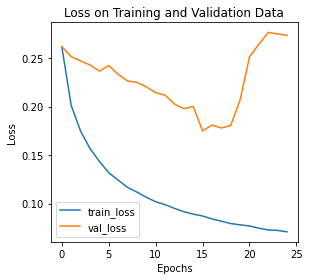

In [19]:
training_vis(train_losses, valid_losses)

In [20]:
# 加载最佳模型权重
checkpoint = torch.load('/WdHeDisk/users/zhangnong/MJO/908_test/cnn_seq2seq_s2s_data_weights.pth')
model = Model()
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [21]:
#测试集300
X1_test_300=X_test
Y_test_300=Y_test

In [22]:
testset = MJODataset(X1_test_300, Y_test_300)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [23]:
Y_test_300=t.from_numpy(Y_test_300)

In [24]:
# 在测试集上评估模型效果
model.eval()
model.to(device)
t_scores_rmse=[]
#t_scores_cor=[]
t_s=0
#t_ss=0
t_preds = np.zeros((len(Y_test_300),35,2))
for i, data in tqdm(enumerate(testloader)):
    data1, labels = data
    data1 = data1.to(device)
    labels = labels.to(device)
    t_pred = model(data1)
    #t_pred= t_pred.permute(0,2,1).contiguous()
    t_preds[i*batch_size:(i+1)*batch_size] = t_pred.detach().cpu()
t_preds=torch.as_tensor(t_preds)
#t_s=rmse(Y_test,t_preds)
t_s=rmse_new(Y_test_300,t_preds)
t_ss=cor(Y_test_300,t_preds)
t_scores_rmse.append(t_s)
#t_scores_cor.append(t_ss)
print('Score_rmse: {:.3f}'.format(t_s))
print('Score_cor: {:.3f}'.format(t_ss))

25it [00:00, 46.92it/s]


Score_rmse: 34.000
Score_cor: 34.000


In [25]:
t_preds=t_preds.numpy()
Y_test_300=Y_test_300.numpy()
#绘制30条数据的rmm指数预测区别，预测和真实值预测
def rmm1_vis_30(Y_test,t_preds,index):
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    ax1.plot(Y_test[index,:,0], label='RMM1:true')
    ax1.plot(t_preds[index,:,0], label='RMM1:pred')
    ax1.set_xlabel('time')
    ax1.set_ylabel('rmm1')
    ax1.set_title('RMM1 on truth and prediction data with time')
    ax1.legend()
    plt.tight_layout()

def rmm2_vis_30(Y_test,t_preds,index):
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    ax1.plot(Y_test[index,:,1], label='RMM2:true')
    ax1.plot(t_preds[index,:,1], label='RMM2:pred')
    ax1.set_xlabel('time')
    ax1.set_ylabel('rmm2')
    ax1.set_title('RMM2 on truth and prediction data with time')
    ax1.legend()
    plt.tight_layout()

In [26]:
print(t_preds.shape)

(400, 35, 2)


In [27]:
#np.save('/WdHeDisk/users/zhangnong/MJO/913_test/data/pred_data.npy', t_preds)

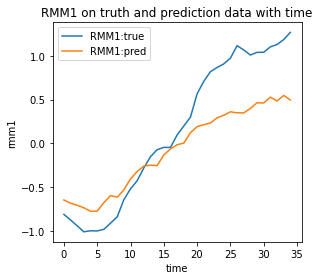

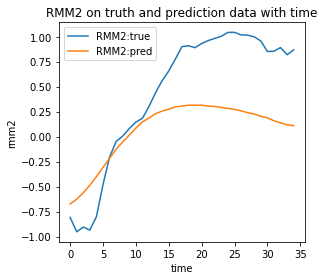

In [28]:
index=0 #可以取0～3200
rmm1_vis_30(Y_test_300,t_preds,index)
rmm2_vis_30(Y_test_300,t_preds,index)